In [1]:
import sys
import os
# sys.path.append('../database/')
import pathlib

import database.interface as db
from optimizer.contest import Contest
from optimizer.lineup import Lineup
from optimizer.projection import covariance
from optimizer.projection import usage
from typing import List

import matplotlib.pyplot as plt
import numpy as np

import jscatter
import warnings

In [2]:
CONTEST = 152678444
NUM_LINEUPS = 20
FIELD_FILE = True
UPLOAD_FILE = True
FILE_SUFFIX = None
EXCLUDE_PLAYERS = [915397, 501150, ]

In [3]:
## Display players and projections to check for any missing data

contest = Contest.Contest(contest_id=CONTEST, db_interface=db.DFSDBInterface())

constraint = Lineup.LineupConstraint(contest_type='Showdown')
draft_group = Lineup.DraftGroup(draft_group_id=contest.draft_group_id, db_interface=db.DFSDBInterface())    
if EXCLUDE_PLAYERS is not None:
        draft_group.exclude(EXCLUDE_PLAYERS)

# Get player projection data
draft_group.populate_points_data(db.DFSDBInterface())

print_cols = ['player_id', 'name', 'position', 'salary', 'projection']
draft_group.data['variance'] = draft_group.data['variance'].fillna(1.0)
df_data = draft_group.data.copy()
df_data = df_data[df_data['roster_slot_id'] == 512]
print(df_data[print_cols].sort_values(by='salary', ascending=False))

     player_id                 name position  salary  projection
29      830517  Christian McCaffrey       RB   12000       18.00
79     1107034        Brandon Aiyuk       WR   10800       16.50
7       403308         Kirk Cousins       QB   10600       15.70
83     1121761          Brock Purdy       QB   10200       17.80
55      923915       T.J. Hockenson       TE    8800       13.50
33      835749         Deebo Samuel       WR    8600       11.60
101    1214250       Jordan Addison       WR    7600       12.40
17      733672        George Kittle       TE    7200       11.10
57      944343   Alexander Mattison       RB    6600       12.30
43      881058          K.J. Osborn       WR    6400       10.90
15      604390        Brandon Allen       QB    6000        0.00
97     1131204           Jaren Hall       QB    6000        0.00
23      748309         Nick Mullens       QB    6000        0.00
9       557860         Sean Mannion       QB    6000        0.00
41      880026          S

In [4]:
## Generate the Field

players = draft_group.data
# Generate all possible lineups
generator = Lineup.greedyGenerator(constraint, players, projections_only=True)
lineups = generator.generate(verbose=True, limit=None, random=False)

# Get the covariance matrix
cov_group = covariance.DraftGroupCovariance(players)
cov_matrix = cov_group.get_covariance()

field = Contest.LineupSet(players, lineups, cov_matrix)
filepath = Contest.field_filename(contest.week, CONTEST)
if FILE_SUFFIX is not None:
    filepath = pathlib.Path((FILE_SUFFIX + '.').join(str(filepath).split('.')))
if FIELD_FILE:
    field.to_file(filepath)
data = field.get_lineup_stats();

10000 lineups generated.
20000 lineups generated.
30000 lineups generated.
40000 lineups generated.
50000 lineups generated.
60000 lineups generated.
70000 lineups generated.
80000 lineups generated.
90000 lineups generated.
100000 lineups generated.
110000 lineups generated.
120000 lineups generated.
130000 lineups generated.


Percent of lineups kept: 0.029749710519283868


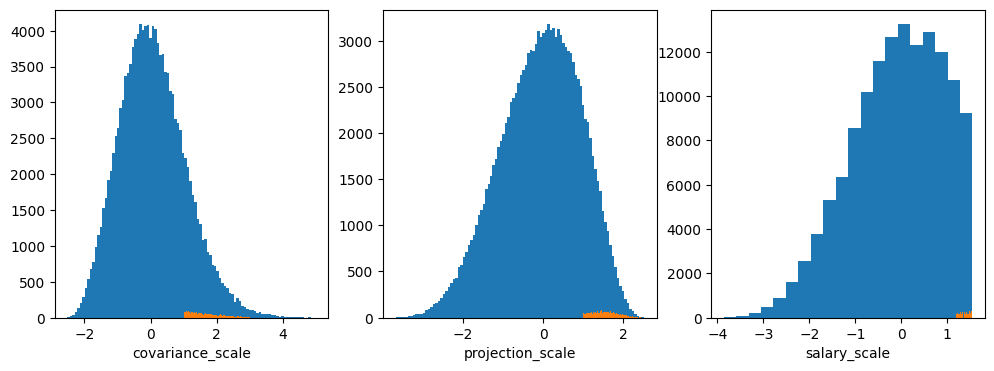

In [5]:
def scale_columns(df, cols):
        # set the median to 0, scale by std deviation
        for col in cols:
            df[col + '_scale'] = (df[col] - np.median(df[col])) / np.std(df[col])
        return df

def filter_lineups(df):
    df = df[(df['covariance_scale'] > 1.) & (df['covariance_scale'] < 3.)]
    df = df[(df['projection_scale'] > 1.) & (df['projection_scale'] < 3.)]
    df = df[df['salary'] > 48000.]
    return df
    
data_scaled = scale_columns(data.copy(), ['covariance', 'projection', 'salary'])
lineup_data = filter_lineups(data_scaled)
print(f'Percent of lineups kept: {len(lineup_data)/len(data_scaled)}')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].hist(data_scaled['covariance_scale'], bins=100)
ax[0].hist(lineup_data['covariance_scale'], bins=100)
ax[0].set_xlabel('covariance_scale')

ax[1].hist(data_scaled['projection_scale'], bins=100)
ax[1].hist(lineup_data['projection_scale'], bins=100)
ax[1].set_xlabel('projection_scale')

ax[2].hist(data_scaled['salary_scale'], bins=20)
ax[2].hist(lineup_data['salary_scale'], bins=20)
ax[2].set_xlabel('salary_scale')
plt.show()

In [6]:
filtered = lineup_data.copy()
field_filtered = field.filter(filtered.index.values)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    selection = field_filtered.generate_max_coverage(NUM_LINEUPS)
    # selection = filtered.index.values
    data['filter_group'] = ['Field']*len(data)
    data.loc[filtered.index.values, 'filter_group'] = ['Filtered']*len(filtered)
    data.loc[filtered.iloc[selection].index.values, 'filter_group'] = ['Selected']*len(selection)
    scatter = jscatter.Scatter(data=data, x='projection', y='covariance')
    scatter.color(by='filter_group')
    scatter.size(by='filter_group', map=[2,2,6])
    scatter.opacity(by='filter_group', map=[0.1, 0.3, 0.5])
    scatter.height(600)
    
scatter.show()

In [7]:
filepath = Contest.field_filename(contest.week, CONTEST)
if FILE_SUFFIX is not None:
    filepath = pathlib.Path((FILE_SUFFIX + '_filtered.').join(str(filepath).split('.')))
else:
    filepath = pathlib.Path(('_filtered.').join(str(filepath).split('.')))
if FIELD_FILE:
    field_filtered.to_file(filepath)

print(selection)
if FILE_SUFFIX is not None:
    filepath = pathlib.Path((FILE_SUFFIX + '.').join(str(filepath).split('.')))
if UPLOAD_FILE:
    Contest.LineupSet.convert_to_uploadable(filepath, selection)

[3110 3909 1588 2825 3136 2245 2617 2953 3880 3888 3986 1941 3999 2641
 3465 3846 3443 3319 3084 3108]
